In [1]:
# Install required packages
!pip install torch transformers pandas numpy scikit-learn seaborn matplotlib tqdm


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.658600
20,0.661500
30,0.645000
40,0.643600
50,0.666900
60,0.679300
70,0.629100
80,0.662200
90,0.631800
100,0.626800



Test Set Evaluation Metrics:
--------------------------------------------------
Accuracy: 68.00%
Precision: 68.00%
Recall: 100.00%
F1 Score: 80.95%

Detailed Classification Report:
--------------------------------------------------
                         precision    recall  f1-score   support

                 Denied       0.00      0.00      0.00        64
Approved/Partially Paid       0.68      1.00      0.81       136

               accuracy                           0.68       200
              macro avg       0.34      0.50      0.40       200
           weighted avg       0.46      0.68      0.55       200


Confusion Matrix:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


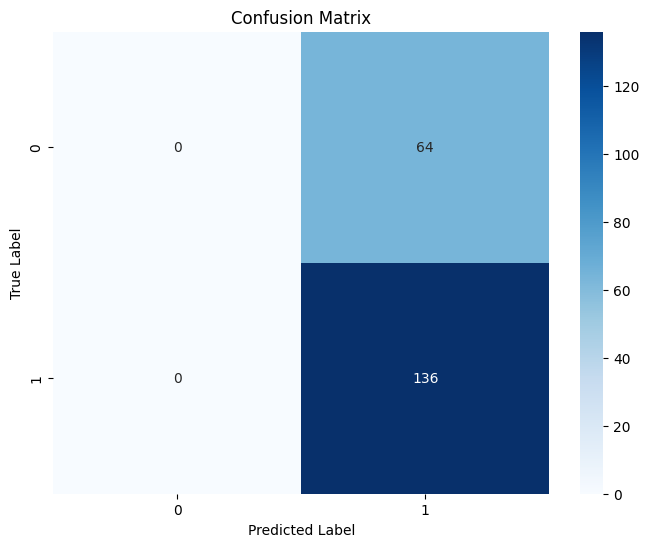

In [2]:

# Import libraries
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import os

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Constants
MODEL_NAME = "emilyalsentzer/Bio_ClinicalBERT"
MAX_LENGTH = 512
BATCH_SIZE = 16
NUM_EPOCHS = 3
LEARNING_RATE = 2e-5
TEST_SIZE = 0.2  # 20% of data for testing

def load_and_split_data(file_path):
    """Load data and split into train and test sets."""
    logger.info("Loading and splitting data...")
    df = pd.read_csv(file_path)

    # Combine relevant fields into a single text field
    df['text'] = df.apply(lambda row: f"Procedure Code: {row['Procedure Code']} " +
                                     f"Diagnosis Code: {row['Diagnosis Code']} " +
                                     f"Insurance Type: {row['Insurance Type']} " +
                                     f"Reason Code: {row['Reason Code']} " +
                                     f"Follow-up Required: {row['Follow-up Required']}", axis=1)

    # Convert outcome to binary (0 for Denied, 1 for Approved/Partially Paid)
    df['label'] = df['Outcome'].apply(lambda x: 0 if x == 'Denied' else 1)

    # Split into train and test sets
    train_df, test_df = train_test_split(df, test_size=TEST_SIZE, random_state=42)

    logger.info(f"Training set size: {len(train_df)}")
    logger.info(f"Test set size: {len(test_df)}")

    return train_df, test_df

def prepare_dataset(df, tokenizer):
    """Prepare the dataset for training or evaluation."""
    # Tokenize the dataset
    encodings = tokenizer(df['text'].tolist(),
                         padding='max_length',
                         truncation=True,
                         max_length=MAX_LENGTH)

    # Convert to PyTorch dataset
    class ClaimsDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.labels)

    return ClaimsDataset(encodings, df['label'].values)

def compute_metrics(pred):
    """Compute metrics for evaluation."""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def plot_confusion_matrix(y_true, y_pred):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def train_model(train_df, test_df):
    """Train the model and return the trained model and tokenizer."""
    # Load tokenizer and model
    logger.info("Loading tokenizer and model...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

    # Prepare datasets
    train_dataset = prepare_dataset(train_df, tokenizer)

    # Set up training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=NUM_EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        learning_rate=LEARNING_RATE,
        save_total_limit=2,
        use_cpu=True  # Use CPU for training
    )

    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        compute_metrics=compute_metrics,
    )

    # Train the model
    logger.info("Starting training...")
    trainer.train()

    # Save the model
    logger.info("Saving model...")
    trainer.save_model('./final_model')
    tokenizer.save_pretrained('./final_model')

    return model, tokenizer

def evaluate_model(model, tokenizer, test_df):
    """Evaluate model on test set and print detailed metrics."""
    logger.info("Evaluating on test set...")

    # Prepare test dataset
    test_dataset = prepare_dataset(test_df, tokenizer)

    # Make predictions
    trainer = Trainer(model=model)
    predictions = trainer.predict(test_dataset)
    preds = predictions.predictions.argmax(-1)

    # Calculate metrics
    accuracy = accuracy_score(test_df['label'], preds)
    precision, recall, f1, _ = precision_recall_fscore_support(test_df['label'], preds, average='binary')

    # Print detailed metrics
    print("\nTest Set Evaluation Metrics:")
    print("-" * 50)
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Precision: {precision:.2%}")
    print(f"Recall: {recall:.2%}")
    print(f"F1 Score: {f1:.2%}")

    # Print classification report
    print("\nDetailed Classification Report:")
    print("-" * 50)
    print(classification_report(test_df['label'], preds,
                              target_names=['Denied', 'Approved/Partially Paid']))

    # Plot confusion matrix
    print("\nConfusion Matrix:")
    plot_confusion_matrix(test_df['label'], preds)

def main():
    # Check if data file exists
    if not os.path.exists('claim_data.csv'):
        print("Error: claim_data.csv not found!")
        print("Please make sure the data file is in the same directory as this script.")
        return

    # Load and split data
    train_df, test_df = load_and_split_data('claim_data.csv')

    # Train model
    model, tokenizer = train_model(train_df, test_df)

    # Evaluate model
    evaluate_model(model, tokenizer, test_df)

if __name__ == "__main__":
    main()